In [99]:
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import osmnx as ox
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point, MultiPoint
from shapely.ops import nearest_points
from shapely import wkt
import itertools
import rasterio
from feature_geometries import *

import pickle
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from pygam import LinearGAM
import os

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

sns.set()
%matplotlib inline
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Import data for feature engineering
*Includes:*
1. OpenStreetMap data
2. EDF mobile mapping data
3. Census tract populations
4. Zoning

## OpenStreetMaps

In [100]:
## Import oakland street and map data
Oakland_poly = ox.gdf_from_place('Oakland, California')

# grab street data (roads and intersections) for entire city
oak_streets = ox.graph_from_place('Oakland, California', network_type = 'drive')
nodes, edges = ox.graph_to_gdfs(oak_streets)

/anaconda3/envs/OSMNX/lib/python3.6/socket.py:657: ResourceWarning: unclosed <socket.socket fd=77, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.0.112', 63662), raddr=('130.117.76.9', 443)>
  self._sock = None
/anaconda3/envs/OSMNX/lib/python3.6/site-packages/osmnx/core.py:262: DeprecationWarning: Flags not at the start of the expression '//(?s)(.*?)/'
  domain = re.findall(r'//(?s)(.*?)/', url)[0]
/anaconda3/envs/OSMNX/lib/python3.6/socket.py:657: ResourceWarning: unclosed <socket.socket fd=77, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.0.112', 63663), raddr=('130.117.76.9', 443)>
  self._sock = None


In [101]:
#remove doubled road IDs, this is only 20 roads out of 22335, but they cause subsetting problems
oakland_rds = remove_doubleID_streets(edges)

# grab subsets of roadtypes
oakland_highways = oakland_rds[oakland_rds.highway == 'motorway']
oakland_primary = oakland_rds[oakland_rds.highway == 'primary']
oakland_secondary = oakland_rds[oakland_rds.highway == 'secondary']
oakland_resid = oakland_rds[oakland_rds.highway == 'residential']

## Google Street View pollutants

In [103]:
## Import GSV data, create shapely points, and convert to geopandas dataframe
GSV_df = pd.read_csv('data/EDF_data.csv', skiprows=1)

geometry = [Point(xy) for xy in zip(GSV_df.Longitude, GSV_df.Latitude)]
GSV_gdf = gpd.GeoDataFrame(GSV_df, geometry=geometry, crs={'init' :'epsg:4326'}) #Mercator lat long input
#GSV_gdf = GSV_gdf.to_crs({'init': 'epsg:32610'}) # tranform to UTM in meters

#subset GSV data in Oakland polygon grid
EDF_points = gpd.sjoin(GSV_gdf, Oakland_poly, how="inner", op="intersects")
EDF_points = EDF_points.rename(index=str, columns={"NO Value": "NO", "NO2 Value": "NO2", "BC Value": "BC"})
EDF_points = EDF_points.drop(['index_right', 'bbox_east', 'bbox_north', 'bbox_south', 'bbox_west'], axis=1)

## Census data

In [104]:
# Import Census data
CA_tracts = import_gpd('data/all_demographics.csv') # see 'Census Imports' notebook to see how this was downloaded

# drop extraneous columns and rename census variables
extra_cols = ['STATEFP', 'COUNTYFP', 'TRACTCE', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'NAME_y', 'NAMELSAD',
              'INTPTLAT', 'INTPTLON']

CA_tracts = CA_tracts.drop(extra_cols, axis=1)
CA_tracts = CA_tracts.rename(index=str, columns = {'B01003_001E': 'population', 'B01003_001M': 'pop_var',
                                                   'NAME_x': 'tract_name'})
CA_tracts.head(3)

,population,pop_var,tract_name,GEOID,state,county,tract,geometry
0,3353,332,"Census Tract 4001, Alameda County, California",6001400100,6,1,400100,"POLYGON ((-122.24692 37.885438, -122.246668 37..."
1,1944,147,"Census Tract 4002, Alameda County, California",6001400200,6,1,400200,"POLYGON ((-122.257923 37.842606, -122.257728 3..."
2,5376,539,"Census Tract 4003, Alameda County, California",6001400300,6,1,400300,"POLYGON ((-122.265631 37.837636, -122.265565 3..."


In [119]:
# calculate area and population density
CA_tracts['area'] = CA_tracts.to_crs({'init': 'epsg:32610'}).geometry.area / 1e6 #km2
CA_tracts['pop_den'] = CA_tracts['population'] / CA_tracts['area']

## Oakland zoning data

In [107]:
## import zoning data
oak_zones = gpd.read_file('data/oakland_zoning/geo_export_cd07e8cc-db0e-41bc-9a7c-b12594fd84da.shp')

# drop extraneous columns
extra_cols = ['overlay', 'date_expir', 'time_expir', 'area', 'znlabel', 'date_updat', 'time_updat', 'date_effct',
              'time_effct']

oak_zones = oak_zones.drop(extra_cols, axis = 1)

## remove null polygons (causes issues with merges)
oak_zones.shape
oak_zones = oak_zones[oak_zones.geometry.notnull()]

oak_zones.head(3)

,perimeter,basezone,ordinance,geometry
0,40159.850561,CIX-1,12875,"POLYGON ((-122.2822453419509 37.8202864225731,..."
1,8355.138459,CIX-1,12875,POLYGON ((-122.2812909540165 37.80236514210691...
2,29069.501825,CIX-1,12875,"POLYGON ((-122.292493335741 37.81916077866173,..."


In [108]:
# lots of zoning information that needs to be cleaned into distinct groups
# Groups: commercial, industrial, residential, open, urban
oak_zones.basezone.unique()

array(['CIX-1', 'OS (NP)', 'RM-1', 'CIX-2', 'OS (AMP)', 'CN-4',
       'OS (RCA)', 'RM-3', 'RD-1', 'CN-3', 'RM-4', 'OS (CP)', 'M-40',
       'RD-2', 'CC-2', 'RM-2', 'CC-1', 'OS (SU)', 'RU-4', 'IG', 'RH-2',
       'S-15', 'CR-1', 'OS (AF)', 'RU-5', 'RU-3', 'RH-3', 'RU-2',
       'OS (LP)', 'CN-2', 'OS (PMP)', 'R-80', 'M-20', 'RH-4', 'C-45',
       'RH-1', 'S-1', 'CN-1', 'RU-1', 'C-40', 'M-30', 'CC-3', 'OS(LP)',
       'OS(NP)', 'OS (RSP)', 'OS(CP)', 'Wood Street', 'S-2', 'HBX-1',
       'D-KP-3', 'D-OTN', 'HBX-2', 'HBX-3', 'IO', 'CBD-P', 'CBD-X',
       'CBD-C', 'CBD-R', 'RU-3/D-BR', 'S-3', 'OS(PMP)', 'D-KP-1',
       'D-KP-2', 'K-DP-4'], dtype=object)

In [109]:
## Basic cleaning of zoning districts 
oak_zones['zone'] = oak_zones['basezone'].apply(lambda x: x.replace(' ', '-').split('-')[0])
oak_zones['zone'] = np.where(oak_zones['zone'].str.contains('OS'), 'open_space', oak_zones['zone'])
oak_zones['zone'] = np.where(oak_zones['zone'].str.contains('Wood'), 'RM', oak_zones['zone'])

print(oak_zones['zone'].unique())

['CIX' 'open_space' 'RM' 'CN' 'RD' 'M' 'CC' 'RU' 'IG' 'RH' 'S' 'CR' 'R'
 'C' 'HBX' 'D' 'IO' 'CBD' 'K']


In [110]:
## zoning designations to be generalized across the Bay Area
residential = ['RM', 'RD', 'RU', 'RH', 'R']
commercial = ['S', 'CR', 'D', 'C', 'K', 'CBD']
industrial = ['IG', 'IO', 'M']
mixed = ['CIX', 'CC', 'HBX', 'CN']

## simply down to the above zoning designations
oak_zones['zone'] = oak_zones['zone'].replace(dict.fromkeys(residential, 'residential'))
oak_zones['zone'] = oak_zones['zone'].replace(dict.fromkeys(commercial, 'commercial'))
oak_zones['zone'] = oak_zones['zone'].replace(dict.fromkeys(mixed, 'mixed'))
oak_zones['zone'] = oak_zones['zone'].replace(dict.fromkeys(industrial, 'industrial'))

print(oak_zones['zone'].unique())

['mixed' 'open_space' 'residential' 'industrial' 'commercial']


In [111]:
# dissolve zones for easy iteration to points later
oak_zones = oak_zones.dissolve(by='zone', aggfunc='sum')
oak_zones = oak_zones.reset_index()

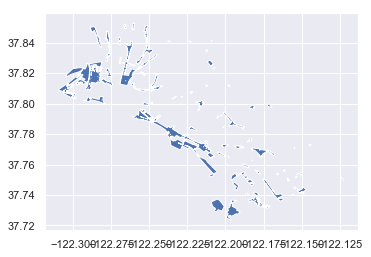

In [112]:
oak_zones[oak_zones.zone == 'mixed'].plot()

# Exploratory plotting

## Pollutants (NO, NO2, BC)

/anaconda3/envs/OSMNX/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


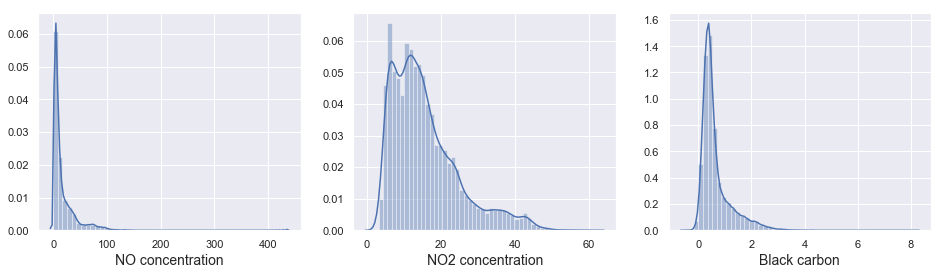

In [113]:
# Plot distribution of pollutants
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
sns.distplot(EDF_points['NO'], ax=ax1); ax1.set_xlabel('NO concentration', fontsize=14)
sns.distplot(EDF_points['NO2'], ax=ax2); ax2.set_xlabel('NO2 concentration', fontsize=14)
sns.distplot(EDF_points['BC'], ax=ax3); ax3.set_xlabel('Black carbon', fontsize=14);

/anaconda3/envs/OSMNX/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


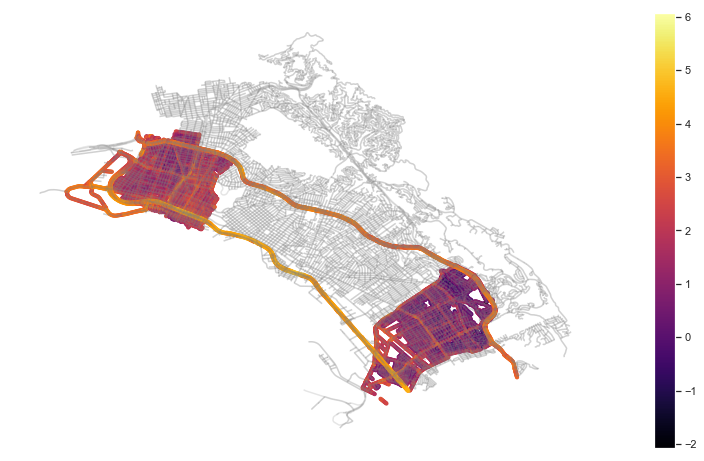

In [114]:
## Plot EDF data with roads
fig, ax = plt.subplots(1, figsize=(20,8))
base = edges.plot(ax=ax, color='gray', alpha=0.2)
plt.scatter(EDF_points.Longitude, EDF_points.Latitude, s=10, c=np.log(EDF_points['NO']), cmap='inferno')
plt.colorbar()
#ax.set_xlim(-122.31, -122.20); ax.set_ylim(37.77, 37.86)
ax.grid(False)
ax.set_facecolor('xkcd:white')
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([]);
#fig.savefig('map.png', format='png', dpi=150)

## Census and zoning

/anaconda3/envs/OSMNX/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


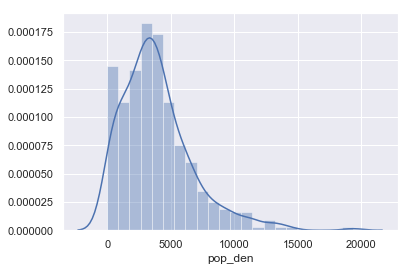

In [115]:
# population densities in Alameda county
Al_tracts = CA_tracts[CA_tracts.county == 1]
sns.distplot(Al_tracts.pop_den);

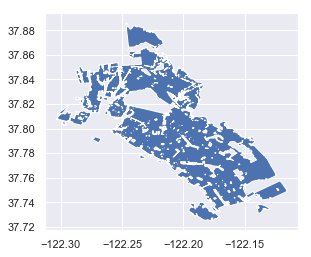

In [116]:
# residential zoning
oak_zones[oak_zones['zone'] == 'residential'].plot();

# Feature engineering

## Roadway distance features

In [117]:
#calculate road_type for each point ...
EDF_points['road_type'] = EDF_points['geometry'].apply(find_closest_road, roads = oakland_rds)

In [118]:
## Calculate distance to nearest major roadway

# much faster to do the re-projection to meters outside of the apply function
EDF_utm = EDF_points.to_crs({'init': 'epsg:32610'}).copy()
highway_utm = oakland_highways.to_crs({'init': 'epsg:32610'}).copy()
primary_utm = oakland_primary.to_crs({'init': 'epsg:32610'}).copy()
secondary_utm = oakland_secondary.to_crs({'init': 'epsg:32610'}).copy()

EDF_points['closest_highway'] = EDF_utm['geometry'].apply(distance_to_roadway, roadway = highway_utm)
EDF_points['closest_primary'] = EDF_utm['geometry'].apply(distance_to_roadway, roadway = primary_utm)
EDF_points['closest_secondary'] = EDF_utm['geometry'].apply(distance_to_roadway, roadway = secondary_utm)

In [120]:
## Calculate distance to nearest intersection and traffic signals
nodes_utm = nodes.to_crs({'init': 'epsg:32610'}).copy() #re-project as above
signals = nodes_utm[nodes_utm['highway'] == 'traffic_signals']

EDF_points['corner_dist'] = EDF_utm['geometry'].apply(nearest_intersection,
                                                            intersections = nodes_utm['geometry'])

EDF_points['signal_dist'] = EDF_utm['geometry'].apply(nearest_intersection, 
                                                               intersections = signals['geometry'])

## Cleaning roadway types
On visual inspection of the maps we can deduce the following to reduce the categories of roadway
1. 'trunk' and 'trunk links' are 'secondary' roads
2. all 'links' can be pushed to their respective roadway
3. 'living_street' is another name for 'residential'

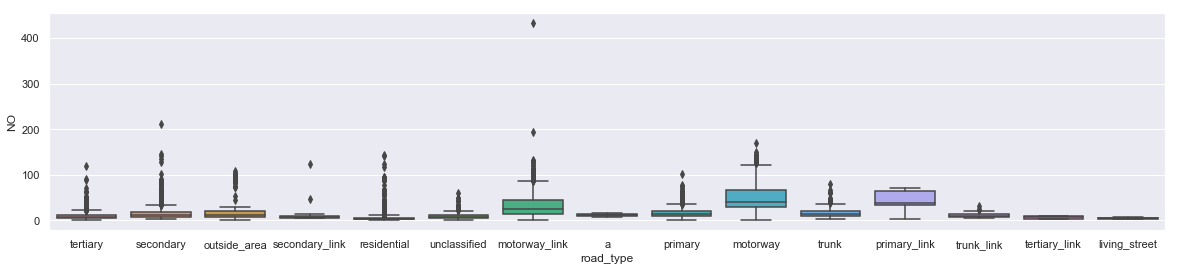

In [121]:
plt.figure(figsize=(20,4))
sns.boxplot(EDF_points['road_type'], EDF_points['NO']);

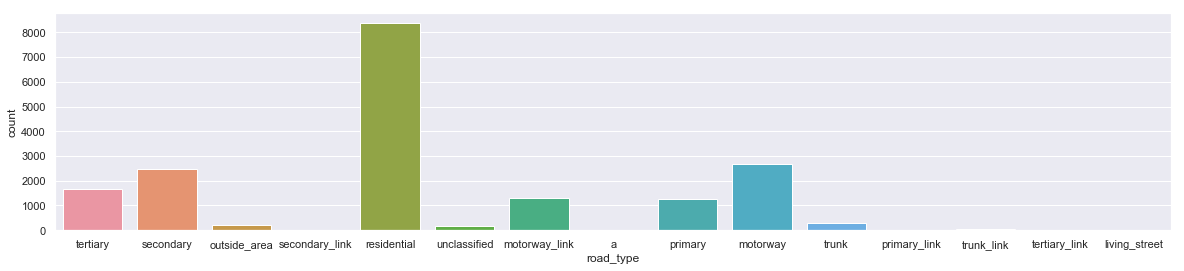

In [122]:
plt.figure(figsize=(20,4))
sns.countplot(x = 'road_type', data = EDF_points);

In [123]:
# Cleaning road categories ...
EDF_points['road_type'] = EDF_points['road_type'].str.replace('_link', '')
EDF_points['road_type'] = np.where(EDF_points['road_type'] == 'trunk', 'secondary', EDF_points['road_type'])
EDF_points['road_type'] = np.where(EDF_points['road_type'] == 'living_street', 'residential', EDF_points['road_type'])
EDF_points['road_type'] = np.where(EDF_points['road_type'] == 'a', 'unclassified', EDF_points['road_type'])

# Drop all point not measured on a OpenStreetMap roadway
EDF_points = EDF_points[EDF_points.road_type != 'outside_area']

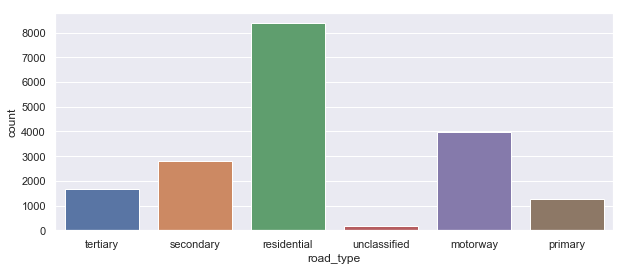

In [124]:
plt.figure(figsize=(10,4))
sns.countplot(EDF_points['road_type']);

## Census and zoning features

In [125]:
# left merge with the zoning data
GSV_all = gpd.sjoin(EDF_points, oak_zones, how='left', op='intersects')

#left merge with the census data
GSV_all = GSV_all.drop(['index_right'], axis = 1)
GSV_all = gpd.sjoin(GSV_all, CA_tracts, how='left', op='intersects')
GSV_all = GSV_all.drop('index_right', axis=1)
GSV_all.shape

(18284, 24)

In [129]:
## Calculate distance to industrial zone
#re-projections
GSV_utm = GSV_all.to_crs({'init': 'epsg:32610'}).copy()
zones_utm = oak_zones.to_crs({'init': 'epsg:32610'}).copy()
industry = zones_utm[zones_utm.zone == 'industrial']

#calculations
GSV_all['industry_dist'] = GSV_utm['geometry'].apply(distance_to_zoning, zone = industry)

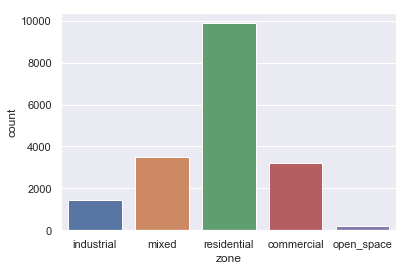

In [130]:
sns.countplot(GSV_all['zone'])

## Weather

In [53]:
#GSV_all = pd.read_csv('GSV_all.csv')

In [56]:
GSV_all = GSV_all.iloc[:, :-2]

In [131]:
# Wind
lons = np.array(GSV_all['Longitude'].values)
lats = np.array(GSV_all['Latitude'].values)
winds = np.zeros(GSV_all.shape[0])

with rasterio.open('data/wc2.0_30s_wind/avg_wind.tif') as src:
    for i, val in enumerate(src.sample(zip(lons, lats))):
        winds[i] = val

# remove below zero values
winds = np.where(winds < 0, np.nan, winds)

GSV_all['wind'] = winds

In [132]:
# Mean annual temperature
temp = np.zeros(GSV_all.shape[0])

with rasterio.open('data/wc2.0_30s_tavg/avg_ta.tif') as src:
    for i, val in enumerate(src.sample(zip(lons, lats))):
        temp[i] = val

# remove below zero values
temp = np.where(temp < 0, np.nan, temp)

GSV_all['temp'] = temp

# Basic Feature Plotting

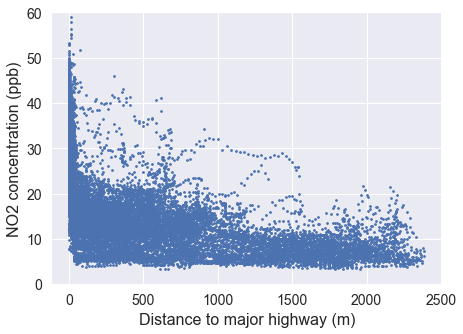

In [133]:
plt.figure(figsize=(7, 5))
plt.scatter(GSV_all['closest_highway'], GSV_all['NO2'], s=3)
plt.ylim(0, 60)
plt.tick_params(labelsize=14)
plt.xlabel('Distance to major highway (m)', fontsize=16); plt.ylabel('NO2 concentration (ppb)', fontsize=16);

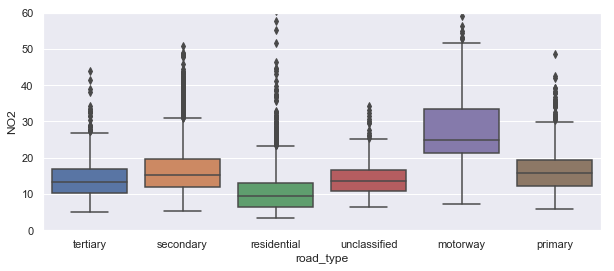

In [135]:
plt.figure(figsize=(10,4))
sns.boxplot(GSV_all['road_type'], GSV_all['NO2'])
plt.ylim([0,60]);

/anaconda3/envs/OSMNX/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


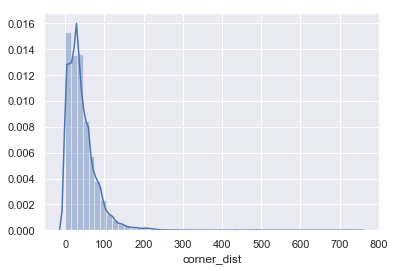

In [136]:
sns.distplot(GSV_all['corner_dist']);

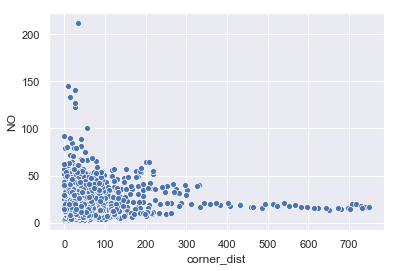

In [137]:
subset = GSV_all[GSV_all.road_type == 'secondary']
sns.scatterplot(subset.corner_dist, subset['NO']);

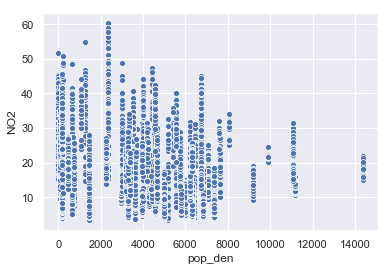

In [138]:
sns.scatterplot(GSV_all['pop_den'], GSV_all['NO2']);

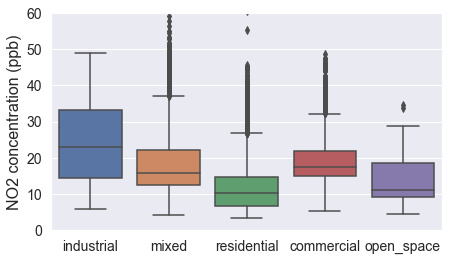

In [139]:
plt.figure(figsize=(7,4))
sns.boxplot(GSV_all['zone'], GSV_all['NO2'])
plt.ylabel('NO2 Concentration (ppb)')
plt.tick_params(labelsize=14)
plt.xlabel(''); plt.ylabel('NO2 concentration (ppb)', fontsize=16);
plt.ylim([0,60]);

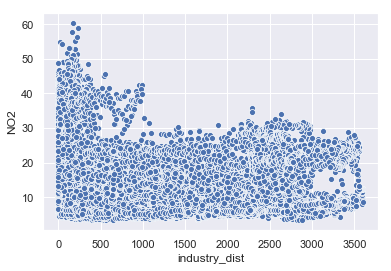

In [140]:
sns.scatterplot(GSV_all['industry_dist'], GSV_all['NO2']);

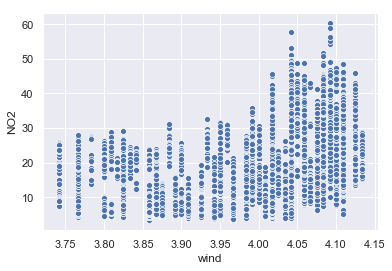

In [141]:
sns.scatterplot(GSV_all['wind'], GSV_all['NO2']);

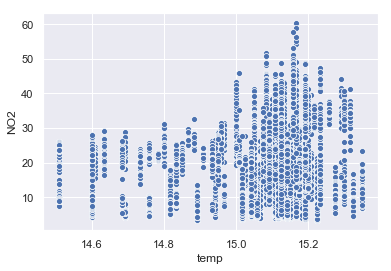

In [142]:
sns.scatterplot(GSV_all['temp'], GSV_all['NO2']);

# Model development

In [143]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '-', color='black')

def pred_summary(pred, ytest, limit = 200):
    """Plotting for test set predictions"""
    sns.scatterplot(pred, ytest)
    abline(1, 0) #1-1 line
    plt.ylim(0, limit); plt.xlim(0, limit)
    plt.xlabel('Predicted'); plt.ylabel('Observed')
    
    print('RMSE', np.sqrt(mean_squared_error(ytest, pred)))
    print('R2', r2_score(ytest, pred))
    
def plot_corr(df, size=10, MI = False):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''
    if MI == False:
        corr = df.corr()
    else:
        K = df.shape[1]
        corr = np.empty((K, K), dtype=float)
        
        for i, ac in enumerate(X.columns):
            for j, bc in enumerate(X.columns):
                MI = mutual_information(X.loc[:, ac], X.loc[:, bc], bins=10, normalize=True)
                corr[i, j] = MI
        
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);

## NO2 model

### Train, test split

In [144]:
GSV_model = GSV_all.dropna() # remove the few NA values in wind and temp (16 total)

# Grab relevant features
X_vars = ['road_type', 'closest_highway', 'closest_primary', 'closest_secondary', 'corner_dist', 'signal_dist',
         'zone', 'pop_den', 'industry_dist', 'wind', 'temp']

X = GSV_model[X_vars]
X = pd.get_dummies(X, columns=['road_type', 'zone']) #create dummy variables for the two categorical features

# remove redundant dummy variables (road_type = 1 is same to zero distance in closest columns)
#X = X.drop(['road_type_motorway', 'road_type_primary', 'road_type_secondary'], axis = 1)

y = GSV_model['NO2']

#train test split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, random_state=0)
print('Train size:', len(ytrain))
print('Test size:', len(ytest))

Train size: 12207
Test size: 6013


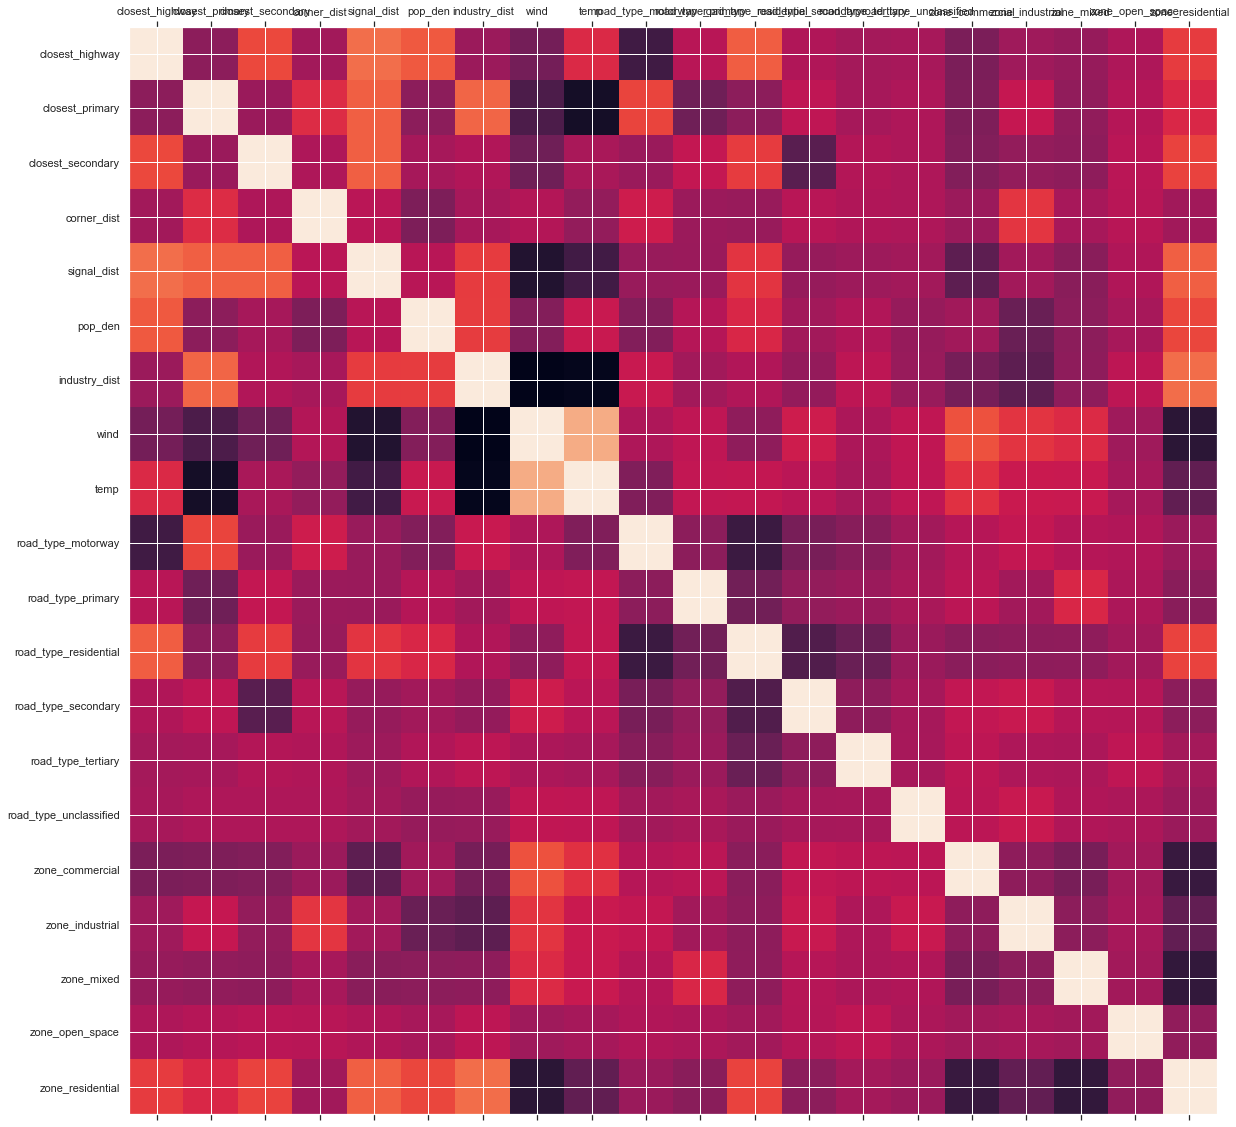

In [145]:
plot_corr(X, size=20, MI = False)

/anaconda3/envs/OSMNX/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


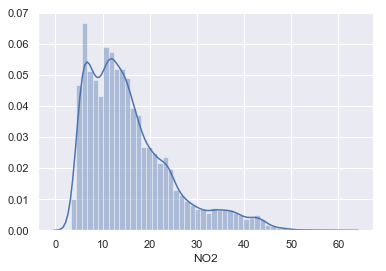

In [146]:
sns.distplot(y);

### Linear model w/ Ridge regularization

In [147]:
# setup pipeline and grid search for cost function
ridge = make_pipeline(StandardScaler(),
                          Ridge(max_iter = 10000))

params = {'ridge__alpha': [0.0001, 0.001, 0.01, 0.1, 1]}
ridge_grid = GridSearchCV(ridge, params, cv=5, scoring = 'neg_mean_squared_error')

#fit the model
ridge_grid.fit(Xtrain, np.log(ytrain + 0.001))

#Best estimator and CV score
print('Best score (MSE)', np.abs(ridge_grid.best_score_))
print(ridge_grid.best_estimator_)

Best score (MSE) 0.07148976045636912
Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ridge', Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, random_state=None, solver='auto', tol=0.001))])


RMSE 5.15655335776614
R2 0.6899439990208177


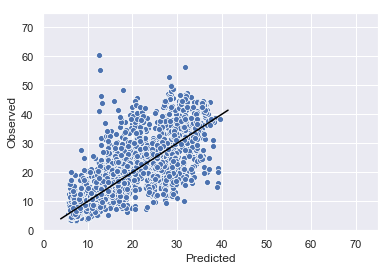

In [148]:
ridge_out = ridge_grid.predict(Xtest)
pred_summary(np.exp(ridge_out), ytest, limit=75)

### Generalized additive model w/ splines

In [149]:
# implement a basic generalized additive model
gam_grid = LinearGAM().gridsearch(Xtrain, ytrain,
                             lam=np.logspace(-3, 3, 11), n_splines=[10, 25, 50])

gam_out = gam_grid.predict(Xtest)

N/A% (0 of 33) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--/anaconda3/envs/OSMNX/lib/python3.6/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
  3% (1 of 33) |                         | Elapsed Time: 0:00:00 ETA:   0:00:23/anaconda3/envs/OSMNX/lib/python3.6/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
  6% (2 of 33) |#                        | Elapsed Time: 0:00:02 ETA:   0:00:32/anaconda3/en

 54% (18 of 33) |#############           | Elapsed Time: 0:00:39 ETA:   0:00:55/anaconda3/envs/OSMNX/lib/python3.6/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
 57% (19 of 33) |#############           | Elapsed Time: 0:00:40 ETA:   0:00:31/anaconda3/envs/OSMNX/lib/python3.6/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
 60% (20 of 33) |##############          | Elapsed Time: 0:00:42 ETA:   0:00:14/anaconda3/en

RMSE 3.525369209825621
R2 0.8550793332237228


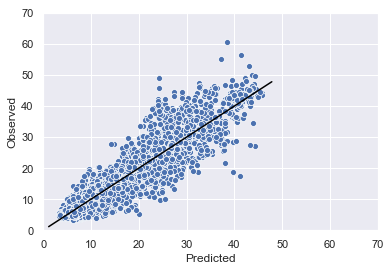

In [150]:
pred_summary(gam_out, ytest, limit=70)

### Tree-based models

#### Random forest

In [162]:
forest = RandomForestRegressor(n_jobs=2)

params = {'max_features': [6, 8, 10],
          'n_estimators': [400, 500, 600]}

forest_grid = GridSearchCV(forest, params, cv=5, scoring = 'neg_mean_squared_error')
forest_grid.fit(Xtrain, ytrain)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': [6, 8, 10], 'n_estimators': [400, 500, 600]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [163]:
#Best estimator and CV score
print('Best score (RMSE)', np.sqrt(np.abs(forest_grid.best_score_)))
print(forest_grid.best_estimator_)
Xtrain.columns

Best score (RMSE) 2.191466746550453
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=10, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=600, n_jobs=2, oob_score=False, random_state=None,
           verbose=0, warm_start=False)


Index(['closest_highway', 'closest_primary', 'closest_secondary',
       'corner_dist', 'signal_dist', 'pop_den', 'industry_dist', 'wind',
       'temp', 'road_type_motorway', 'road_type_primary',
       'road_type_residential', 'road_type_secondary', 'road_type_tertiary',
       'road_type_unclassified', 'zone_commercial', 'zone_industrial',
       'zone_mixed', 'zone_open_space', 'zone_residential'],
      dtype='object')

RMSE 2.0812416131952656
R2 0.949491309287787


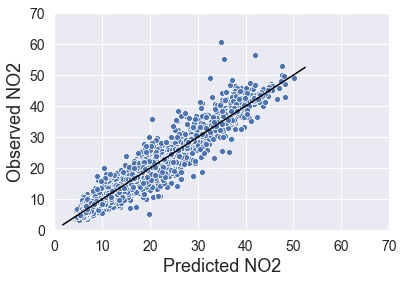

In [164]:
def pred_summary(pred, ytest, limit = 200):
    """Plotting for test set predictions"""
    sns.scatterplot(pred, ytest)
    abline(1, 0) #1-1 line
    plt.ylim(0, limit); plt.xlim(0, limit)
    plt.tick_params(labelsize=14)
    plt.xlabel('Predicted NO2', fontsize = 18); plt.ylabel('Observed NO2', fontsize=18)
    
    print('RMSE', np.sqrt(mean_squared_error(ytest, pred)))
    print('R2', r2_score(ytest, pred))

forest_out = forest_grid.predict(Xtest)
pred_summary(forest_out, ytest, limit=70)

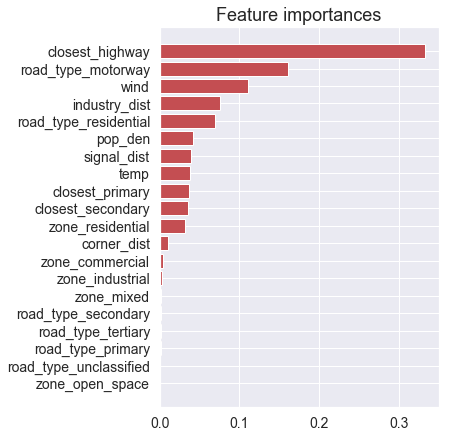

In [165]:
features = X.columns
importance = forest_grid.best_estimator_.feature_importances_
indices = np.argsort(importance)
plt.figure(figsize=(5, 7))
plt.title("Feature importances", fontsize = 18)
plt.barh(features[indices], importance[indices],
       color="r",  align="center")
plt.tick_params(labelsize=14);

#### Gradient boosting trees

In [151]:
xgb = XGBRegressor(n_jobs=4)

params = {'max_depth': [2, 3, 5, 10],
          'learning_rate': [0.005, 0.01, 0.05, 0.1, 1],
          'n_estimators': [100, 500, 1000]}

xgb_grid = RandomizedSearchCV(xgb, params, cv=5, scoring = 'neg_mean_squared_error')

xgb_grid.fit(Xtrain, ytrain)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=4, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'max_depth': [2, 3, 5, 10], 'learning_rate': [0.005, 0.01, 0.05, 0.1, 1], 'n_estimators': [100, 500, 1000]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [152]:
#Best estimator and CV score
print('Best score (RMSE)', np.sqrt(np.abs(xgb_grid.best_score_)))
print(xgb_grid.best_estimator_)

Best score (RMSE) 2.2649239581891805
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=4, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


RMSE 2.1371310057386483
R2 0.9467421782692022


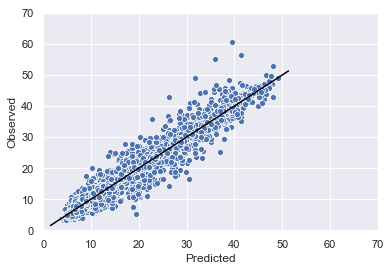

In [153]:
xgb_out = xgb_grid.predict(Xtest)
pred_summary(xgb_out, ytest, limit=70)

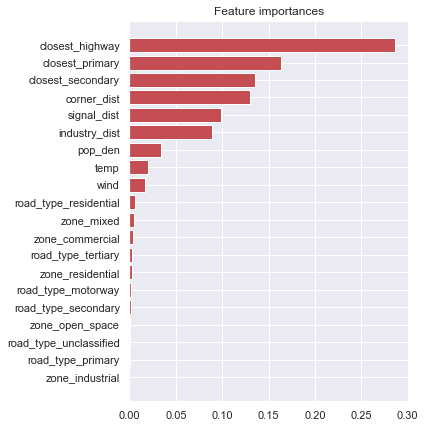

In [154]:
features = X.columns
importance = xgb_grid.best_estimator_.feature_importances_
indices = np.argsort(importance)
plt.figure(figsize=(5, 7))
plt.title("Feature importances")
plt.barh(features[indices], importance[indices],
       color="r",  align="center");

## Black carbon model
Here I will just jump straight to the best predictive tree models

In [155]:
## Train, test splots for black carbon model
bc = GSV_model['BC']

#train test split
Xtrain_bc, Xtest_bc, ytrain_bc, ytest_bc = train_test_split(X, bc, test_size=0.33, random_state=0)
print('Train size:', len(ytrain_bc))
print('Test size:', len(ytest_bc))

Train size: 12207
Test size: 6013


### Random forest model

In [166]:
# Use the same random forest gridsearch as above
forest = RandomForestRegressor(n_jobs=2)

params = {'max_features': [6, 8, 10],
          'n_estimators': [400, 500, 600]}

forest_grid_bc = GridSearchCV(forest, params, cv=5, scoring = 'neg_mean_squared_error')
forest_grid_bc.fit(Xtrain_bc, ytrain_bc)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': [6, 8, 10], 'n_estimators': [400, 500, 600]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [167]:
#Best estimator and CV score
print('Best score (RMSE)', np.sqrt(np.abs(forest_grid_bc.best_score_)))
print(forest_grid_bc.best_estimator_)

Best score (RMSE) 0.22947944676844925
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=10, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=400, n_jobs=2, oob_score=False, random_state=None,
           verbose=0, warm_start=False)


RMSE 0.2202144228604464
R2 0.8502814823957109


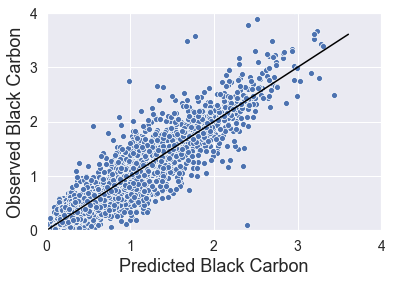

In [168]:
def pred_summary(pred, ytest, limit = 200):
    """Plotting for test set predictions"""
    sns.scatterplot(pred, ytest)
    abline(1, 0) #1-1 line
    plt.ylim(0, limit); plt.xlim(0, limit)
    plt.tick_params(labelsize=14)
    plt.xlabel('Predicted Black Carbon', fontsize = 18); plt.ylabel('Observed Black Carbon', fontsize=18)
        
    print('RMSE', np.sqrt(mean_squared_error(ytest, pred)))
    print('R2', r2_score(ytest, pred))

forest_out = forest_grid_bc.predict(Xtest_bc)
pred_summary(forest_out, ytest_bc, limit=4)

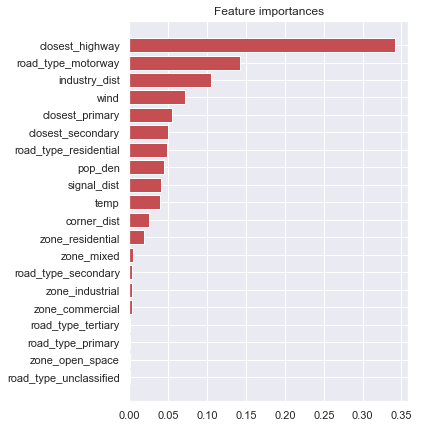

In [169]:
features = X.columns
importance = forest_grid_bc.best_estimator_.feature_importances_
indices = np.argsort(importance)
plt.figure(figsize=(5, 7))
plt.title("Feature importances")
plt.barh(features[indices], importance[indices],
       color="r",  align="center");

### Gradient Boosting

In [156]:
xgb = XGBRegressor(n_jobs=2)

params = {'max_depth': [2, 3, 5, 10],
          'learning_rate': [0.005, 0.01, 0.05, 0.1, 1],
          'n_estimators': [100, 500, 1000]}

xgb_grid_bc = RandomizedSearchCV(xgb, params, cv=5, scoring = 'neg_mean_squared_error')
xgb_grid_bc.fit(Xtrain_bc, ytrain_bc)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=2, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'max_depth': [2, 3, 5, 10], 'learning_rate': [0.005, 0.01, 0.05, 0.1, 1], 'n_estimators': [100, 500, 1000]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [157]:
#Best estimator and CV score
print('Best score (RMSE)', np.sqrt(np.abs(xgb_grid_bc.best_score_)))
print(xgb_grid_bc.best_estimator_)

Best score (RMSE) 0.23575223180631996
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=2, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


RMSE 0.2312479767248163
R2 0.8349027335476716


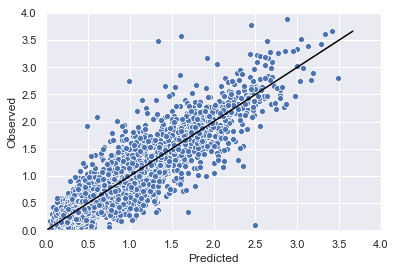

In [158]:
xgb_out_bc = xgb_grid_bc.predict(Xtest_bc)
pred_summary(xgb_out_bc, ytest_bc, limit=4)

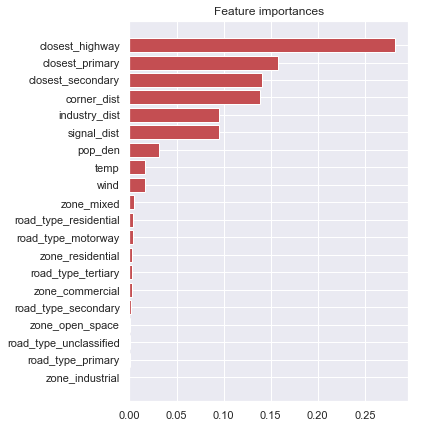

In [159]:
features = X.columns
importance = xgb_grid_bc.best_estimator_.feature_importances_
indices = np.argsort(importance)
plt.figure(figsize=(5, 7))
plt.title("Feature importances")
plt.barh(features[indices], importance[indices],
       color="r",  align="center");

In [171]:
# pickle the random forest model for now
decision_tree_pkl_filename = 'rf_bc.pkl'
# Open the file to save as pkl file
decision_tree_model_pkl = open(decision_tree_pkl_filename, 'wb')
pickle.dump(forest_grid_bc.best_estimator_, decision_tree_model_pkl)
# Close the pickle instances
decision_tree_model_pkl.close()

In [172]:
GSV_all.to_csv('GSV_all.csv')